<a href="https://colab.research.google.com/github/esorq/ml-portfolio/blob/main/House_price_prediction_on_the_California_Housing_dataset_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# House price Regression on the California Housing dataset 

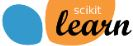
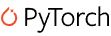
-----------
The purpose of this notebook is to take advantage of the PyTorch and sklearn libraries in order to solve a regression problem. 

This dataset was derived from the 1990 U.S. census, using one row per census block group. A block group is the smallest geographical unit for which the U.S. Census Bureau publishes sample data (a block group typically has a population of 600 to 3,000 people).

An household is a group of people residing within a home. Since the average number of rooms and bedrooms in this dataset are provided per household, these columns may take surpinsingly large values for block groups with few households and many empty houses, such as vacation resorts. It consists of input samples with 8 features that regresses to a target variable. The target variable is the median house value for California districts, expressed in hundreds of thousands of dollars ($100,000). 

-----------
Workflow for solving a classifaction problem of this nature:
1. Prepare and analyze data
2. Pick or build a model
3. Pick a loss function and optimizer
4. Build a training loop / Train the model
5. Evaluate the model
6. Propose changes / improve model

## 1. **Preparing**, **visualizing** and **analyzing** data

### 1.0 Loading the dataset

In [177]:
from sklearn.datasets import fetch_california_housing

#Creating a dataset object´and printing some general information
data = fetch_california_housing()

print(f"Number of samples: {len(data.target)}\nNumber of featuers = {len(data.feature_names)}\nFeatures names: {data.feature_names}\nTargets: {data.target_names}") 


Number of samples: 20640
Number of featuers = 8
Features names: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
Targets: ['MedHouseVal']


In [178]:
import pandas as pd

# Visualizing the data in a pandas dataframe
df = pd.DataFrame(data.data, columns=data.feature_names)
df["target"]= data.target
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [179]:
# Dividing the features and labels/targets into two separate variebles and displaying the first sample 
X = data.data
y = data.target
X[0], y[0]

(array([   8.3252    ,   41.        ,    6.98412698,    1.02380952,
         322.        ,    2.55555556,   37.88      , -122.23      ]), 4.526)

### 1.1 Scaling the data with `sklearn.preprocessing.StandardScaler`

Standardize features by removing the mean and scaling to unit variance.

The standard score of a sample x is calculated as:

z = (x - u) / s

In [180]:
#Using
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
transformed = scaler.fit_transform(X)
X[0], transformed[0]

(array([   8.3252    ,   41.        ,    6.98412698,    1.02380952,
         322.        ,    2.55555556,   37.88      , -122.23      ]),
 array([ 2.34476576,  0.98214266,  0.62855945, -0.15375759, -0.9744286 ,
        -0.04959654,  1.05254828, -1.32783522]))

### 1.2 Splitting the dataset into training and testing data with `sklearn.model_selection.train_test_split`

In [181]:
import torch
from torch import nn

# Make device agnostic code, this is done in order to bring data, models and other objects onto the same device. If objects are on different devices they will not be able to interact with each other. 
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [182]:
# First turn data from numpy arrays into tensors since PyTorch models expect tensor inputs for training
import torch
X = torch.from_numpy(transformed).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [183]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproducible
len(X_train), len(X_test), len(y_train), len(y_test)

(16512, 4128, 16512, 4128)

In [184]:
X_train = X_train.to(device)
X_test= X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

### 1.3 Creating a torch dataset

In [185]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.labels = labels
        self.features = features
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        label = self.labels[idx]
        features = self.features[idx]
        return features, label

In [186]:
train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)

In [187]:
# Display text and label.
print(f"First iteration of dataset: {train_dataset.__getitem__(0)}")
print(f'Length of train data set: {train_dataset.__len__()}\n')
# Print entire data set
#print('Entire data set: ', list(DataLoader(td)), '\n')

First iteration of dataset: (tensor([-0.3217,  0.3465, -0.1663, -0.1905,  0.7723,  0.0598, -1.3680,  1.2676]), tensor(1.0300))
Length of train data set: 16512



### 1.4 Loading torch train dataset into torch dataloader

The dataloader is used to batch the data for training.

In [188]:
from torch.utils.data import DataLoader

In [189]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=50, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)
len(train_dataloader)

331

In [190]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([50, 8]), torch.Size([50]))

In [191]:
# Lets get a sample from the dataloader and see what i yields
features, targets = next(iter(train_dataloader))
print(f"This is the size the first batch consisting of 10 samples with 8 features in each sample: {features.shape}")
print(f"This are the targets for these 10 samples: {targets}")

This is the size the first batch consisting of 10 samples with 8 features in each sample: torch.Size([50, 8])
This are the targets for these 10 samples: tensor([0.8820, 1.1250, 3.3100, 2.6820, 4.8680, 1.5000, 3.3560, 1.5550, 2.6180,
        0.8780, 1.6540, 2.9610, 1.7830, 1.3350, 2.3660, 2.0650, 2.1460, 3.1150,
        3.5230, 1.7270, 0.5770, 2.1810, 1.8100, 1.8070, 2.4350, 1.9090, 1.0810,
        2.2050, 0.8270, 3.1690, 1.5840, 1.0400, 2.0000, 1.5500, 1.4950, 1.7380,
        3.3930, 5.0000, 4.9640, 1.7210, 0.8190, 1.2130, 0.7170, 4.0000, 0.9960,
        2.5330, 1.4690, 1.4200, 1.5630, 0.6690])


## 2. **Choose** or **build** a model

In [192]:
input_shape = X_train.shape[1]        # number fo features in the input data sample
output_shape = len(data.target_names) # number of different classes
hidden_neurons = 5                   # number fo hidden neureons in the hidden layer
hn1 = 100
hn2 = 50
hn3 = 10

# 1. Construct a model class that subclasses nn.Module
class RegressionModelV0(nn.Module):
    def __init__(self,input_shape, output_shape, hidden_neurons):
        super().__init__()
        # 2. Create 2 nn.Linear layers capable of handling X and y input and output shapes
        self.layer_1 = nn.Linear(in_features=input_shape, out_features=hn1) # takes in 2 features (X), produces 5 features
        self.layer_2 = nn.ReLU()
        self.layer_3 = nn.Linear(in_features=hn1, out_features=hn2) # takes in 5 features, produces 1 feature (y)
        self.layer_4 = nn.ReLU()
        self.layer_5 = nn.Linear(in_features=hn2, out_features=hn3)
        self.layer_6 = nn.ReLU()
        self.layer_7 = nn.Linear(in_features=hn3, out_features=output_shape)
    # 3. Define a forward method containing the forward pass computation
    def forward(self, x):
        
        
        return self.layer_7(self.layer_6(self.layer_5(self.layer_4(self.layer_3(self.layer_2(self.layer_1(x)))))))


In [193]:
# 4. Create an object instance of the model and send it to target device
torch.manual_seed(42)
model_0 = RegressionModelV0(input_shape=input_shape, output_shape=output_shape, hidden_neurons=hidden_neurons).to(device)
model_0

RegressionModelV0(
  (layer_1): Linear(in_features=8, out_features=100, bias=True)
  (layer_2): ReLU()
  (layer_3): Linear(in_features=100, out_features=50, bias=True)
  (layer_4): ReLU()
  (layer_5): Linear(in_features=50, out_features=10, bias=True)
  (layer_6): ReLU()
  (layer_7): Linear(in_features=10, out_features=1, bias=True)
)

## 3. **Choose** a loss function and optimizer
---------

In [194]:
# Create a loss function
#loss_fn=nn.MSELoss(reduction='sum')
loss_fn = nn.L1Loss()
#loss_fn = nn.BCELoss() # BCELoss = no sigmoid built-in
#loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid built-in

# Create an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), 
                            lr=0.0001)# the learning rate(lr) is one important hyperparamter that control how big steps we take in every update. To small -> it can take forever to get to the loss minimum and to big -> we migth miss the loss minimum by taking to big of a step.

In [195]:
optimizer = torch.optim.RMSprop(model_0.parameters(), lr=0.0001)
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)

### 3.1 **Run** a test on untrained model

In [196]:
from sklearn.metrics import r2_score
torch.manual_seed(42)
#Testing the test_dataset
model_0.eval()
with torch.inference_mode():
    # 1. Forward pass
    y_preds = []
    test_loss = 0

    for batch, (X, y) in enumerate(test_dataloader):
      model_0.train()
      # 1. Forward pass
      y_pred = model_0(X)

      y_preds.append(y_pred.item())# add prediction to list for r2 score

      # 2. Calculate loss (per batch)
      loss = loss_fn(y_pred, y.unsqueeze(dim=1))
      test_loss += loss.item() # accumulate train loss
      
    r2_s = r2_score(test_dataset.labels.cpu().detach().numpy(), y_preds)
    # Divide total train loss by length of train dataloader
    test_loss /= len(test_dataloader)
    # Print out what's happening
    print(f"\nAverage test loss: {test_loss:.4f}\nR2 Score: {r2_s}")


Average test loss: 1.7764
R2 Score: -2.40077314976151


##4. **Build** a training looop
-----------

In [197]:
from sklearn.metrics import accuracy_score # importing this metric which will be used to track progress during training

In [198]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# Set the seed and start the timer
torch.manual_seed(42)

# Set the number of epochs (we'll keep this small for faster training time)
epochs = 100

#Store values for visualization
loss_viz = []
epoch_viz = []

# Create training and test loop
for epoch in tqdm(range(epochs)):
  if epoch % 10 == 0:
    print(f"Epoch: {epoch}")

  ### Training
  train_loss = 0
  # Add a loop to loop through the training batches
  for batch, (X, y) in enumerate(train_dataloader):
    model_0.train()
    # 1. Forward pass
    y_pred = model_0(X)
    
    # 2. Calculate loss (per batch)
    loss = loss_fn(y_pred, y.unsqueeze(dim=1))
    train_loss += loss # accumulate train loss
    # 3. Optimizer zero grad
    optimizer.zero_grad()
    
    

    # 4. Loss backward
    loss.backward()
    
    # 5. Optimizer step (update the model's parameters once *per batch*)
    optimizer.step()
    
    # Print out what's happening
    #if batch % 200 == 0:
        #print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples.")
  
  # Divide total train loss by length of train dataloader
  train_loss /= len(train_dataloader)

  # append for visualization
  loss_viz.append(train_loss.item())#.item() appends a python integer/float instead of a tensor
  epoch_viz.append(epoch)
  # Print out progress
  if epoch % 10 == 0:
    print(f"\nTrain loss: {train_loss:.4f}\n------")
 

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0

Train loss: 0.6318
------
Epoch: 10

Train loss: 0.3636
------
Epoch: 20

Train loss: 0.3442
------
Epoch: 30

Train loss: 0.3346
------
Epoch: 40

Train loss: 0.3241
------
Epoch: 50

Train loss: 0.3163
------
Epoch: 60

Train loss: 0.3130
------
Epoch: 70

Train loss: 0.3083
------
Epoch: 80

Train loss: 0.3024
------
Epoch: 90

Train loss: 0.2987
------


## 5. **Evaluate** the model
----------


The Model is evaluated by running the test dataset in `torch.inference_mode()`
results are presented with metrics from `sklearn.metrics` and visualized with a confusion matrix!

In [199]:
from sklearn.metrics import r2_score
torch.manual_seed(42)
#Testing the test_dataset
model_0.eval()
with torch.inference_mode():
    # 1. Forward pass
    y_preds = []
    test_loss = 0

    for batch, (X, y) in enumerate(test_dataloader):
      model_0.train()
      # 1. Forward pass
      y_pred = model_0(X)

      y_preds.append(y_pred.item())# add prediction to list for r2 score

      # 2. Calculate loss (per batch)
      loss = loss_fn(y_pred, y.unsqueeze(dim=1))
      test_loss += loss.item() # accumulate train loss
      
    r2_s = r2_score(test_dataset.labels.cpu().detach().numpy(), y_preds)
    # Divide total train loss by length of train dataloader
    test_loss /= len(test_dataloader)
    # Print out what's happening
    print(f"\nAverage test loss: {test_loss:.4f}\nR2 Score: {r2_s}")





Average test loss: 0.3226
R2 Score: 0.8048236227645738


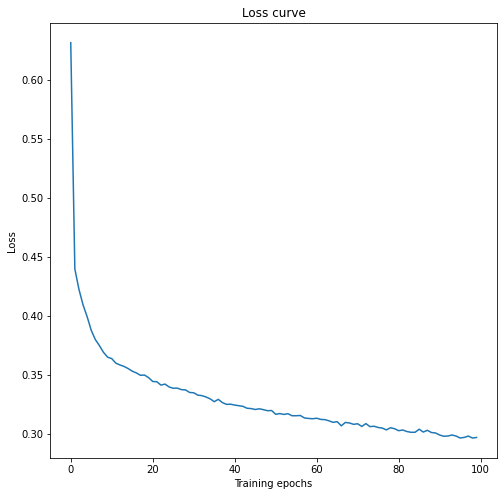

In [200]:
from matplotlib import pyplot as plt
     

#Plotting the loss as a function of training epochs
plt.figure(figsize=(8,8))
plt.plot(epoch_viz, loss_viz)
plt.title("Loss curve")
plt.xlabel("Training epochs")
plt.ylabel("Loss")
plt.show()

## 6. **Propose** changes / **improve** model
-----------

Hyperparamters that comes to mind that can be adjusted in a project like this and possibly improve performance:

* Layer architecture
  * number of layers 
  * number of neurons per layer
  * kind of layers 
  * activation functions.
* Training epochs
* Loss function
* Optimizer
  * learning rate
  * momentum
* The Scaling approach of initial data
* Adjust the batch size for the dataloader